# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

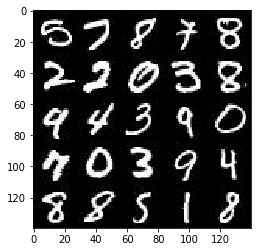

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

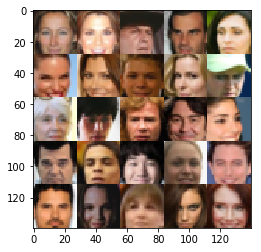

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [55]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_image = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name = "real_input_image")
    z = tf.placeholder(tf.float32, [None, z_dim], name = "z")
    learning_rate = tf.placeholder(tf.float32, name = "learning_rate")
    return real_input_image, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [56]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.nn.dropout(relu1, 0.8)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, 0.8)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, 0.8)
        # 4x4x256

        # Flatten it
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [57]:
a = 7*7*256
b = 28*28*3
print(a)
print(b)

12544
2352


In [58]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256) #orig = 4*4*512 -- 28*28*3
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.5)
        # 7*7*256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.5)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.5)
        # 14*14*128 now
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        #x3 = tf.layers.batch_normalization(x3, training=is_train)
        #x3 = tf.maximum(alpha * x3, x3)
        # 28*28*out_channel_dim now
        
        # Output layer
        #logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [59]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse = False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [60]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [61]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [62]:
import matplotlib.pyplot as plt
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [63]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, _ = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    _ = show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.1533... Generator Loss: 0.5214
Epoch 1/2... Discriminator Loss: 2.5204... Generator Loss: 0.7668
Epoch 1/2... Discriminator Loss: 2.0182... Generator Loss: 1.4490
Epoch 1/2... Discriminator Loss: 1.7340... Generator Loss: 0.9049
Epoch 1/2... Discriminator Loss: 1.4197... Generator Loss: 0.8872
Epoch 1/2... Discriminator Loss: 2.0165... Generator Loss: 0.3158
Epoch 1/2... Discriminator Loss: 2.4414... Generator Loss: 0.1456
Epoch 1/2... Discriminator Loss: 1.8858... Generator Loss: 0.2904
Epoch 1/2... Discriminator Loss: 1.5363... Generator Loss: 0.5851
Epoch 1/2... Discriminator Loss: 1.4806... Generator Loss: 0.7416


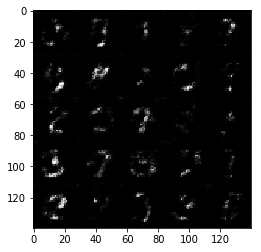

Epoch 1/2... Discriminator Loss: 1.5954... Generator Loss: 0.4667
Epoch 1/2... Discriminator Loss: 1.7894... Generator Loss: 0.5257
Epoch 1/2... Discriminator Loss: 1.4191... Generator Loss: 0.7701
Epoch 1/2... Discriminator Loss: 1.5509... Generator Loss: 1.2105
Epoch 1/2... Discriminator Loss: 1.6252... Generator Loss: 0.4112
Epoch 1/2... Discriminator Loss: 1.6468... Generator Loss: 1.0785
Epoch 1/2... Discriminator Loss: 1.6589... Generator Loss: 0.4461
Epoch 1/2... Discriminator Loss: 1.4368... Generator Loss: 0.7662
Epoch 1/2... Discriminator Loss: 1.7344... Generator Loss: 0.9395
Epoch 1/2... Discriminator Loss: 1.5216... Generator Loss: 1.0145


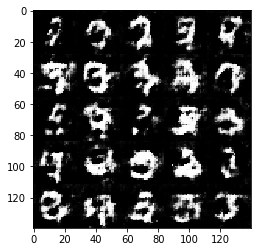

Epoch 1/2... Discriminator Loss: 1.5959... Generator Loss: 0.5407
Epoch 1/2... Discriminator Loss: 1.7256... Generator Loss: 1.0547
Epoch 1/2... Discriminator Loss: 1.7536... Generator Loss: 1.3446
Epoch 1/2... Discriminator Loss: 1.3644... Generator Loss: 0.8054
Epoch 1/2... Discriminator Loss: 1.9453... Generator Loss: 0.2677
Epoch 1/2... Discriminator Loss: 1.5030... Generator Loss: 0.5968
Epoch 1/2... Discriminator Loss: 1.6087... Generator Loss: 1.2107
Epoch 1/2... Discriminator Loss: 1.6199... Generator Loss: 0.9727
Epoch 1/2... Discriminator Loss: 1.4351... Generator Loss: 0.4896
Epoch 1/2... Discriminator Loss: 1.6922... Generator Loss: 0.3151


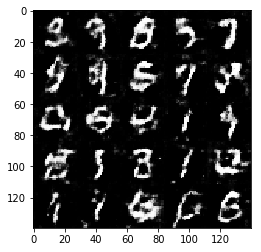

Epoch 1/2... Discriminator Loss: 1.4086... Generator Loss: 0.9123
Epoch 1/2... Discriminator Loss: 1.4852... Generator Loss: 1.0542
Epoch 1/2... Discriminator Loss: 1.5512... Generator Loss: 0.9256
Epoch 1/2... Discriminator Loss: 1.3516... Generator Loss: 0.5732
Epoch 1/2... Discriminator Loss: 1.7333... Generator Loss: 0.3051
Epoch 1/2... Discriminator Loss: 1.4279... Generator Loss: 0.5111
Epoch 1/2... Discriminator Loss: 1.5954... Generator Loss: 0.3906
Epoch 1/2... Discriminator Loss: 1.4075... Generator Loss: 0.7227
Epoch 1/2... Discriminator Loss: 1.6589... Generator Loss: 0.3505
Epoch 1/2... Discriminator Loss: 1.3557... Generator Loss: 0.8590


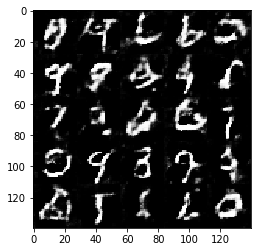

Epoch 1/2... Discriminator Loss: 1.3383... Generator Loss: 0.4097
Epoch 1/2... Discriminator Loss: 1.3528... Generator Loss: 0.4196
Epoch 1/2... Discriminator Loss: 1.8584... Generator Loss: 0.2127
Epoch 1/2... Discriminator Loss: 1.4222... Generator Loss: 0.4227
Epoch 1/2... Discriminator Loss: 1.2881... Generator Loss: 0.6315
Epoch 1/2... Discriminator Loss: 1.3611... Generator Loss: 0.5002
Epoch 1/2... Discriminator Loss: 1.5460... Generator Loss: 0.4618
Epoch 1/2... Discriminator Loss: 1.2813... Generator Loss: 0.7728
Epoch 1/2... Discriminator Loss: 1.3378... Generator Loss: 1.1324
Epoch 1/2... Discriminator Loss: 1.2191... Generator Loss: 0.9081


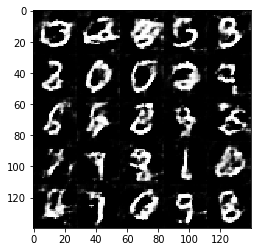

Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 1.2142
Epoch 1/2... Discriminator Loss: 1.5026... Generator Loss: 0.3899
Epoch 1/2... Discriminator Loss: 1.2999... Generator Loss: 0.6904
Epoch 1/2... Discriminator Loss: 1.1800... Generator Loss: 0.5326
Epoch 1/2... Discriminator Loss: 1.3305... Generator Loss: 0.9051
Epoch 1/2... Discriminator Loss: 1.8367... Generator Loss: 0.2408
Epoch 1/2... Discriminator Loss: 1.3346... Generator Loss: 0.5694
Epoch 1/2... Discriminator Loss: 1.3127... Generator Loss: 0.4980
Epoch 1/2... Discriminator Loss: 1.3058... Generator Loss: 1.0364
Epoch 1/2... Discriminator Loss: 1.6338... Generator Loss: 0.4122


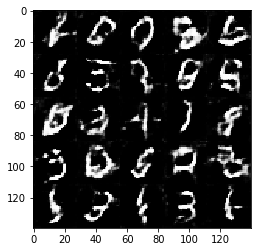

Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 0.6742
Epoch 1/2... Discriminator Loss: 1.3701... Generator Loss: 1.1460
Epoch 1/2... Discriminator Loss: 1.2979... Generator Loss: 0.9441
Epoch 1/2... Discriminator Loss: 1.3336... Generator Loss: 1.4938
Epoch 1/2... Discriminator Loss: 1.3971... Generator Loss: 0.3776
Epoch 1/2... Discriminator Loss: 1.3427... Generator Loss: 0.9802
Epoch 1/2... Discriminator Loss: 1.5459... Generator Loss: 0.3299
Epoch 1/2... Discriminator Loss: 1.4566... Generator Loss: 0.4587
Epoch 1/2... Discriminator Loss: 1.4023... Generator Loss: 0.4739
Epoch 1/2... Discriminator Loss: 1.8856... Generator Loss: 0.2187


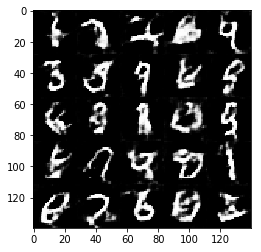

Epoch 1/2... Discriminator Loss: 1.1011... Generator Loss: 0.7730
Epoch 1/2... Discriminator Loss: 1.2132... Generator Loss: 0.5310
Epoch 1/2... Discriminator Loss: 1.7458... Generator Loss: 0.2946
Epoch 1/2... Discriminator Loss: 1.1625... Generator Loss: 0.7267
Epoch 1/2... Discriminator Loss: 1.2096... Generator Loss: 0.5183
Epoch 1/2... Discriminator Loss: 1.3241... Generator Loss: 0.7093
Epoch 1/2... Discriminator Loss: 0.9751... Generator Loss: 0.9797
Epoch 1/2... Discriminator Loss: 1.1925... Generator Loss: 0.8485
Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 1.2116
Epoch 1/2... Discriminator Loss: 1.4115... Generator Loss: 0.4046


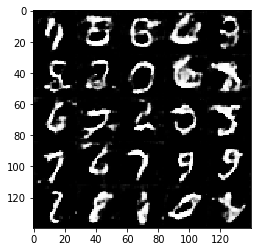

Epoch 1/2... Discriminator Loss: 1.2396... Generator Loss: 0.6053
Epoch 1/2... Discriminator Loss: 1.2811... Generator Loss: 0.5088
Epoch 1/2... Discriminator Loss: 1.1940... Generator Loss: 0.7044
Epoch 1/2... Discriminator Loss: 0.8740... Generator Loss: 0.6599
Epoch 1/2... Discriminator Loss: 1.0153... Generator Loss: 1.4643
Epoch 1/2... Discriminator Loss: 1.3747... Generator Loss: 1.1830
Epoch 1/2... Discriminator Loss: 1.2490... Generator Loss: 0.8474
Epoch 1/2... Discriminator Loss: 1.1829... Generator Loss: 1.0048
Epoch 1/2... Discriminator Loss: 1.0866... Generator Loss: 0.6227
Epoch 1/2... Discriminator Loss: 1.4357... Generator Loss: 0.3554


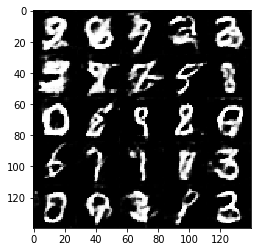

Epoch 1/2... Discriminator Loss: 1.0729... Generator Loss: 0.8496
Epoch 1/2... Discriminator Loss: 1.1592... Generator Loss: 0.5992
Epoch 1/2... Discriminator Loss: 1.6646... Generator Loss: 0.3801
Epoch 1/2... Discriminator Loss: 1.0276... Generator Loss: 0.8266
Epoch 1/2... Discriminator Loss: 1.1955... Generator Loss: 0.5692
Epoch 1/2... Discriminator Loss: 1.1587... Generator Loss: 0.7009
Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 1.6543
Epoch 1/2... Discriminator Loss: 1.2799... Generator Loss: 1.9984
Epoch 1/2... Discriminator Loss: 1.1184... Generator Loss: 0.6402
Epoch 1/2... Discriminator Loss: 1.0723... Generator Loss: 0.8391


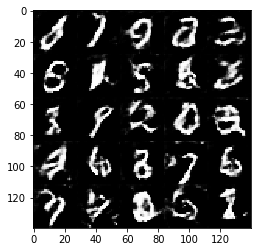

Epoch 1/2... Discriminator Loss: 1.2044... Generator Loss: 0.6334
Epoch 1/2... Discriminator Loss: 1.6857... Generator Loss: 0.2214
Epoch 1/2... Discriminator Loss: 1.2685... Generator Loss: 0.6109
Epoch 1/2... Discriminator Loss: 1.2781... Generator Loss: 1.1139
Epoch 1/2... Discriminator Loss: 1.0809... Generator Loss: 0.4856
Epoch 1/2... Discriminator Loss: 1.6507... Generator Loss: 0.2580
Epoch 1/2... Discriminator Loss: 0.8482... Generator Loss: 0.8044
Epoch 1/2... Discriminator Loss: 1.9071... Generator Loss: 0.2554
Epoch 1/2... Discriminator Loss: 0.8996... Generator Loss: 1.2436
Epoch 1/2... Discriminator Loss: 0.9650... Generator Loss: 1.6916


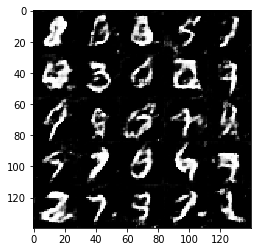

Epoch 1/2... Discriminator Loss: 1.1247... Generator Loss: 0.5708
Epoch 1/2... Discriminator Loss: 1.1247... Generator Loss: 0.7426
Epoch 1/2... Discriminator Loss: 1.2601... Generator Loss: 0.4119
Epoch 1/2... Discriminator Loss: 0.9921... Generator Loss: 2.5767
Epoch 1/2... Discriminator Loss: 1.1041... Generator Loss: 0.5443
Epoch 1/2... Discriminator Loss: 0.8752... Generator Loss: 1.5975
Epoch 1/2... Discriminator Loss: 0.9659... Generator Loss: 1.5742
Epoch 1/2... Discriminator Loss: 0.6435... Generator Loss: 1.5079
Epoch 1/2... Discriminator Loss: 1.0015... Generator Loss: 0.9556
Epoch 1/2... Discriminator Loss: 0.9815... Generator Loss: 0.9490


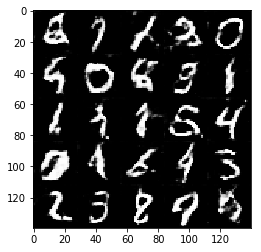

Epoch 1/2... Discriminator Loss: 0.8053... Generator Loss: 1.0108
Epoch 1/2... Discriminator Loss: 0.8953... Generator Loss: 0.8239
Epoch 1/2... Discriminator Loss: 0.8461... Generator Loss: 0.8093
Epoch 1/2... Discriminator Loss: 1.6443... Generator Loss: 0.4813
Epoch 1/2... Discriminator Loss: 1.0056... Generator Loss: 0.7191
Epoch 1/2... Discriminator Loss: 1.1023... Generator Loss: 2.3045
Epoch 1/2... Discriminator Loss: 0.7300... Generator Loss: 0.8638
Epoch 1/2... Discriminator Loss: 1.1386... Generator Loss: 2.5179
Epoch 1/2... Discriminator Loss: 0.9946... Generator Loss: 1.4267
Epoch 1/2... Discriminator Loss: 0.8115... Generator Loss: 1.0870


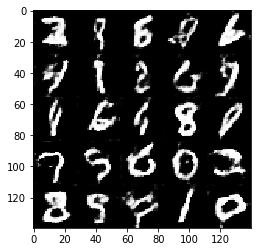

Epoch 1/2... Discriminator Loss: 0.9058... Generator Loss: 0.8957
Epoch 1/2... Discriminator Loss: 1.0620... Generator Loss: 1.0847
Epoch 1/2... Discriminator Loss: 1.1574... Generator Loss: 0.9580
Epoch 1/2... Discriminator Loss: 0.9480... Generator Loss: 1.0318
Epoch 1/2... Discriminator Loss: 0.7255... Generator Loss: 1.7399
Epoch 1/2... Discriminator Loss: 0.9126... Generator Loss: 1.6025
Epoch 1/2... Discriminator Loss: 0.5870... Generator Loss: 2.0395
Epoch 1/2... Discriminator Loss: 0.9473... Generator Loss: 2.1301
Epoch 1/2... Discriminator Loss: 1.8024... Generator Loss: 0.2696
Epoch 1/2... Discriminator Loss: 1.1488... Generator Loss: 1.7353


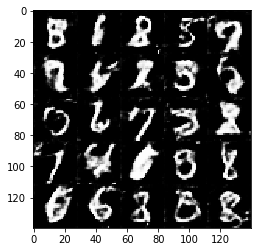

Epoch 1/2... Discriminator Loss: 0.8581... Generator Loss: 0.7880
Epoch 1/2... Discriminator Loss: 0.7600... Generator Loss: 1.3138
Epoch 1/2... Discriminator Loss: 0.6571... Generator Loss: 1.3722
Epoch 1/2... Discriminator Loss: 0.5954... Generator Loss: 2.5252
Epoch 1/2... Discriminator Loss: 0.6567... Generator Loss: 1.2200
Epoch 1/2... Discriminator Loss: 0.7145... Generator Loss: 1.1528
Epoch 1/2... Discriminator Loss: 2.0910... Generator Loss: 0.3500
Epoch 1/2... Discriminator Loss: 0.7523... Generator Loss: 1.2509
Epoch 1/2... Discriminator Loss: 0.7038... Generator Loss: 1.2055
Epoch 1/2... Discriminator Loss: 0.8649... Generator Loss: 1.1496


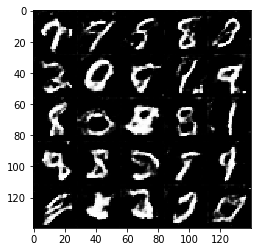

Epoch 1/2... Discriminator Loss: 0.7478... Generator Loss: 1.1849
Epoch 1/2... Discriminator Loss: 1.3950... Generator Loss: 0.5297
Epoch 1/2... Discriminator Loss: 1.2223... Generator Loss: 0.6248
Epoch 1/2... Discriminator Loss: 0.8269... Generator Loss: 1.3849
Epoch 1/2... Discriminator Loss: 0.5241... Generator Loss: 1.2646
Epoch 1/2... Discriminator Loss: 0.6306... Generator Loss: 2.1694
Epoch 1/2... Discriminator Loss: 0.5452... Generator Loss: 1.3637
Epoch 1/2... Discriminator Loss: 0.9206... Generator Loss: 2.6520
Epoch 1/2... Discriminator Loss: 0.4521... Generator Loss: 1.5554
Epoch 1/2... Discriminator Loss: 0.8696... Generator Loss: 0.5931


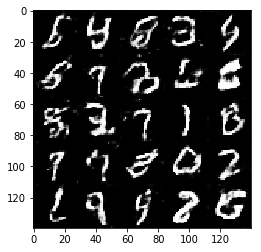

Epoch 1/2... Discriminator Loss: 0.9969... Generator Loss: 2.9971
Epoch 1/2... Discriminator Loss: 1.0070... Generator Loss: 0.5754
Epoch 1/2... Discriminator Loss: 0.6297... Generator Loss: 0.8660
Epoch 1/2... Discriminator Loss: 1.0835... Generator Loss: 0.6991
Epoch 1/2... Discriminator Loss: 1.1484... Generator Loss: 0.7072
Epoch 1/2... Discriminator Loss: 0.6472... Generator Loss: 1.0756
Epoch 1/2... Discriminator Loss: 0.9574... Generator Loss: 3.1102
Epoch 1/2... Discriminator Loss: 0.4518... Generator Loss: 1.0418
Epoch 1/2... Discriminator Loss: 0.5265... Generator Loss: 2.6205
Epoch 1/2... Discriminator Loss: 2.2157... Generator Loss: 0.4140


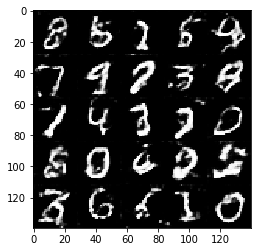

Epoch 1/2... Discriminator Loss: 0.8279... Generator Loss: 1.5540
Epoch 1/2... Discriminator Loss: 0.5261... Generator Loss: 2.0720
Epoch 1/2... Discriminator Loss: 0.9282... Generator Loss: 3.9555
Epoch 1/2... Discriminator Loss: 0.9623... Generator Loss: 0.7304
Epoch 1/2... Discriminator Loss: 0.7663... Generator Loss: 2.8043
Epoch 1/2... Discriminator Loss: 0.4809... Generator Loss: 2.4804
Epoch 1/2... Discriminator Loss: 0.5408... Generator Loss: 1.4838
Epoch 1/2... Discriminator Loss: 2.4609... Generator Loss: 3.5178
Epoch 1/2... Discriminator Loss: 1.2438... Generator Loss: 1.7287
Epoch 1/2... Discriminator Loss: 0.5157... Generator Loss: 1.4771


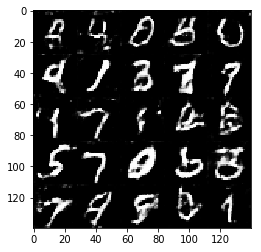

Epoch 1/2... Discriminator Loss: 0.5798... Generator Loss: 1.7609
Epoch 1/2... Discriminator Loss: 0.5542... Generator Loss: 1.6202
Epoch 1/2... Discriminator Loss: 0.5980... Generator Loss: 1.9013
Epoch 1/2... Discriminator Loss: 0.5679... Generator Loss: 2.5922
Epoch 1/2... Discriminator Loss: 0.3262... Generator Loss: 2.7666
Epoch 1/2... Discriminator Loss: 0.5713... Generator Loss: 2.1715
Epoch 1/2... Discriminator Loss: 0.3854... Generator Loss: 2.0370
Epoch 2/2... Discriminator Loss: 0.5446... Generator Loss: 2.2666
Epoch 2/2... Discriminator Loss: 0.8219... Generator Loss: 1.2550
Epoch 2/2... Discriminator Loss: 0.5668... Generator Loss: 1.4370


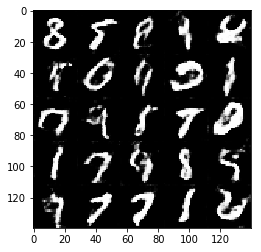

Epoch 2/2... Discriminator Loss: 0.6132... Generator Loss: 2.4603
Epoch 2/2... Discriminator Loss: 0.6608... Generator Loss: 1.7318
Epoch 2/2... Discriminator Loss: 1.1899... Generator Loss: 0.4509
Epoch 2/2... Discriminator Loss: 0.8666... Generator Loss: 0.8393
Epoch 2/2... Discriminator Loss: 0.3650... Generator Loss: 2.5220
Epoch 2/2... Discriminator Loss: 0.7885... Generator Loss: 1.1719
Epoch 2/2... Discriminator Loss: 0.6136... Generator Loss: 1.9697
Epoch 2/2... Discriminator Loss: 0.7284... Generator Loss: 1.2132
Epoch 2/2... Discriminator Loss: 0.5524... Generator Loss: 1.2538
Epoch 2/2... Discriminator Loss: 0.7939... Generator Loss: 2.6140


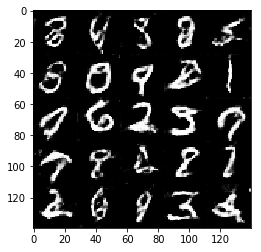

Epoch 2/2... Discriminator Loss: 0.4137... Generator Loss: 2.4110
Epoch 2/2... Discriminator Loss: 0.3405... Generator Loss: 1.9423
Epoch 2/2... Discriminator Loss: 0.4110... Generator Loss: 1.8081
Epoch 2/2... Discriminator Loss: 0.3514... Generator Loss: 2.9308
Epoch 2/2... Discriminator Loss: 1.1302... Generator Loss: 3.9277
Epoch 2/2... Discriminator Loss: 0.6719... Generator Loss: 2.8048
Epoch 2/2... Discriminator Loss: 0.6663... Generator Loss: 0.9262
Epoch 2/2... Discriminator Loss: 0.5621... Generator Loss: 2.1531
Epoch 2/2... Discriminator Loss: 1.0266... Generator Loss: 1.0412
Epoch 2/2... Discriminator Loss: 0.5530... Generator Loss: 2.2429


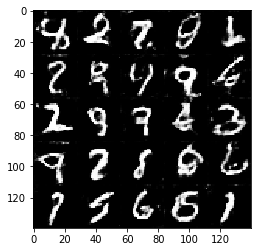

Epoch 2/2... Discriminator Loss: 0.5969... Generator Loss: 1.6778
Epoch 2/2... Discriminator Loss: 0.4014... Generator Loss: 2.0529
Epoch 2/2... Discriminator Loss: 0.2864... Generator Loss: 1.6179
Epoch 2/2... Discriminator Loss: 0.3329... Generator Loss: 2.0308
Epoch 2/2... Discriminator Loss: 0.4883... Generator Loss: 3.6612
Epoch 2/2... Discriminator Loss: 0.3296... Generator Loss: 2.5617
Epoch 2/2... Discriminator Loss: 0.4002... Generator Loss: 1.9860
Epoch 2/2... Discriminator Loss: 0.3018... Generator Loss: 1.3915
Epoch 2/2... Discriminator Loss: 0.8831... Generator Loss: 0.8194
Epoch 2/2... Discriminator Loss: 1.3612... Generator Loss: 3.3789


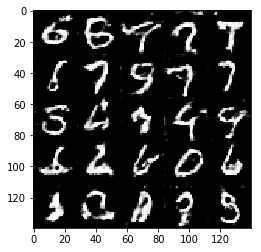

Epoch 2/2... Discriminator Loss: 0.5142... Generator Loss: 1.5434
Epoch 2/2... Discriminator Loss: 0.6884... Generator Loss: 3.4986
Epoch 2/2... Discriminator Loss: 0.8171... Generator Loss: 1.6606
Epoch 2/2... Discriminator Loss: 0.6307... Generator Loss: 1.5479
Epoch 2/2... Discriminator Loss: 0.2164... Generator Loss: 2.1917
Epoch 2/2... Discriminator Loss: 0.8569... Generator Loss: 1.1603
Epoch 2/2... Discriminator Loss: 0.3223... Generator Loss: 2.6095
Epoch 2/2... Discriminator Loss: 0.7167... Generator Loss: 1.1221
Epoch 2/2... Discriminator Loss: 1.0379... Generator Loss: 0.6937
Epoch 2/2... Discriminator Loss: 1.4920... Generator Loss: 0.4599


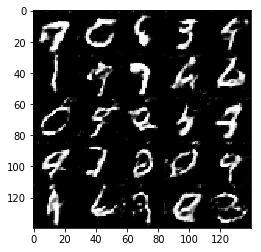

Epoch 2/2... Discriminator Loss: 0.4446... Generator Loss: 3.4580
Epoch 2/2... Discriminator Loss: 0.4515... Generator Loss: 1.4576
Epoch 2/2... Discriminator Loss: 0.4406... Generator Loss: 2.2527
Epoch 2/2... Discriminator Loss: 0.5401... Generator Loss: 1.7493
Epoch 2/2... Discriminator Loss: 0.3775... Generator Loss: 2.4790
Epoch 2/2... Discriminator Loss: 0.3825... Generator Loss: 3.3732
Epoch 2/2... Discriminator Loss: 0.5519... Generator Loss: 1.3958
Epoch 2/2... Discriminator Loss: 0.4130... Generator Loss: 3.0953
Epoch 2/2... Discriminator Loss: 1.1223... Generator Loss: 4.7103
Epoch 2/2... Discriminator Loss: 0.5322... Generator Loss: 1.6405


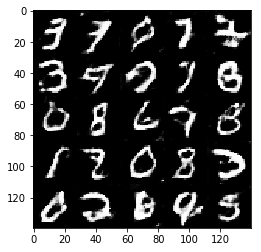

Epoch 2/2... Discriminator Loss: 0.3580... Generator Loss: 2.0075
Epoch 2/2... Discriminator Loss: 0.4035... Generator Loss: 2.3042
Epoch 2/2... Discriminator Loss: 0.4841... Generator Loss: 3.9595
Epoch 2/2... Discriminator Loss: 0.1612... Generator Loss: 2.5485
Epoch 2/2... Discriminator Loss: 1.0865... Generator Loss: 0.8177
Epoch 2/2... Discriminator Loss: 0.4096... Generator Loss: 2.2566
Epoch 2/2... Discriminator Loss: 1.6789... Generator Loss: 6.3918
Epoch 2/2... Discriminator Loss: 0.6066... Generator Loss: 4.2370
Epoch 2/2... Discriminator Loss: 0.4344... Generator Loss: 2.0852
Epoch 2/2... Discriminator Loss: 0.3161... Generator Loss: 2.1158


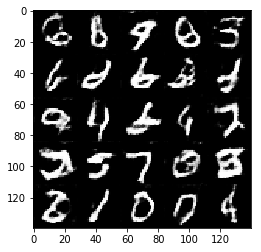

Epoch 2/2... Discriminator Loss: 0.2952... Generator Loss: 2.1717
Epoch 2/2... Discriminator Loss: 1.0824... Generator Loss: 0.7615
Epoch 2/2... Discriminator Loss: 0.9327... Generator Loss: 1.4464
Epoch 2/2... Discriminator Loss: 0.2531... Generator Loss: 2.2063
Epoch 2/2... Discriminator Loss: 0.2614... Generator Loss: 2.2425
Epoch 2/2... Discriminator Loss: 0.7544... Generator Loss: 1.4751
Epoch 2/2... Discriminator Loss: 0.5249... Generator Loss: 3.4740
Epoch 2/2... Discriminator Loss: 0.3541... Generator Loss: 2.1872
Epoch 2/2... Discriminator Loss: 0.3719... Generator Loss: 2.1162
Epoch 2/2... Discriminator Loss: 0.3211... Generator Loss: 2.0449


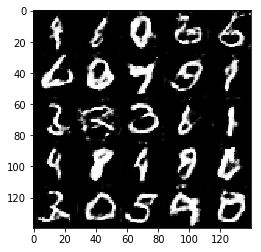

Epoch 2/2... Discriminator Loss: 0.2157... Generator Loss: 4.2044
Epoch 2/2... Discriminator Loss: 0.5279... Generator Loss: 1.5307
Epoch 2/2... Discriminator Loss: 0.6348... Generator Loss: 2.0404
Epoch 2/2... Discriminator Loss: 0.1431... Generator Loss: 1.6621
Epoch 2/2... Discriminator Loss: 0.7421... Generator Loss: 1.4158
Epoch 2/2... Discriminator Loss: 0.1432... Generator Loss: 1.9862
Epoch 2/2... Discriminator Loss: 0.2290... Generator Loss: 2.2253
Epoch 2/2... Discriminator Loss: 0.8071... Generator Loss: 1.3727
Epoch 2/2... Discriminator Loss: 0.5301... Generator Loss: 4.6577
Epoch 2/2... Discriminator Loss: 0.5722... Generator Loss: 2.0222


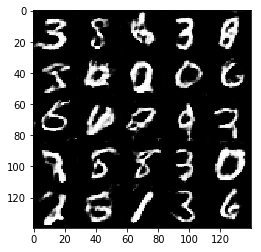

Epoch 2/2... Discriminator Loss: 0.7027... Generator Loss: 1.2771
Epoch 2/2... Discriminator Loss: 1.2234... Generator Loss: 1.1143
Epoch 2/2... Discriminator Loss: 0.3345... Generator Loss: 2.4519
Epoch 2/2... Discriminator Loss: 0.4482... Generator Loss: 2.3447
Epoch 2/2... Discriminator Loss: 0.2666... Generator Loss: 3.3873
Epoch 2/2... Discriminator Loss: 0.4029... Generator Loss: 3.7481
Epoch 2/2... Discriminator Loss: 0.4170... Generator Loss: 2.8416
Epoch 2/2... Discriminator Loss: 0.4991... Generator Loss: 2.0080
Epoch 2/2... Discriminator Loss: 0.4747... Generator Loss: 2.7478
Epoch 2/2... Discriminator Loss: 0.2869... Generator Loss: 2.0027


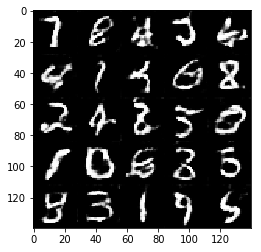

Epoch 2/2... Discriminator Loss: 0.5076... Generator Loss: 4.3487
Epoch 2/2... Discriminator Loss: 0.2775... Generator Loss: 3.0630
Epoch 2/2... Discriminator Loss: 0.7252... Generator Loss: 3.4898
Epoch 2/2... Discriminator Loss: 1.0432... Generator Loss: 0.5701
Epoch 2/2... Discriminator Loss: 0.9357... Generator Loss: 5.5920
Epoch 2/2... Discriminator Loss: 0.3244... Generator Loss: 4.7104
Epoch 2/2... Discriminator Loss: 0.3393... Generator Loss: 2.4327
Epoch 2/2... Discriminator Loss: 0.2886... Generator Loss: 1.6407
Epoch 2/2... Discriminator Loss: 0.4104... Generator Loss: 3.1444
Epoch 2/2... Discriminator Loss: 0.6401... Generator Loss: 1.7453


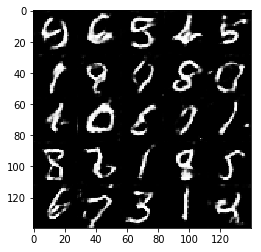

Epoch 2/2... Discriminator Loss: 0.6735... Generator Loss: 2.9228
Epoch 2/2... Discriminator Loss: 0.3801... Generator Loss: 1.5379
Epoch 2/2... Discriminator Loss: 0.3704... Generator Loss: 2.1881
Epoch 2/2... Discriminator Loss: 0.1576... Generator Loss: 3.1968
Epoch 2/2... Discriminator Loss: 0.2285... Generator Loss: 3.5149
Epoch 2/2... Discriminator Loss: 0.5340... Generator Loss: 3.1074
Epoch 2/2... Discriminator Loss: 0.5491... Generator Loss: 1.3570
Epoch 2/2... Discriminator Loss: 0.2948... Generator Loss: 3.3720
Epoch 2/2... Discriminator Loss: 0.3860... Generator Loss: 2.6912
Epoch 2/2... Discriminator Loss: 0.9713... Generator Loss: 6.7290


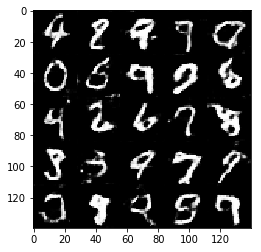

Epoch 2/2... Discriminator Loss: 0.2804... Generator Loss: 4.6216
Epoch 2/2... Discriminator Loss: 0.2238... Generator Loss: 2.2679
Epoch 2/2... Discriminator Loss: 0.2225... Generator Loss: 3.0065
Epoch 2/2... Discriminator Loss: 0.5634... Generator Loss: 1.9255
Epoch 2/2... Discriminator Loss: 0.9884... Generator Loss: 1.5017
Epoch 2/2... Discriminator Loss: 0.1944... Generator Loss: 4.6406
Epoch 2/2... Discriminator Loss: 0.6016... Generator Loss: 1.5581
Epoch 2/2... Discriminator Loss: 2.7568... Generator Loss: 0.1209
Epoch 2/2... Discriminator Loss: 1.2729... Generator Loss: 6.0256
Epoch 2/2... Discriminator Loss: 0.4865... Generator Loss: 1.3533


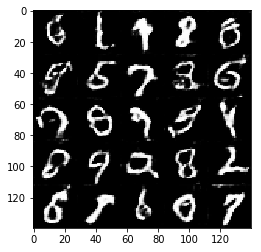

Epoch 2/2... Discriminator Loss: 0.3029... Generator Loss: 2.7389
Epoch 2/2... Discriminator Loss: 0.2183... Generator Loss: 2.8116
Epoch 2/2... Discriminator Loss: 0.1455... Generator Loss: 2.4620
Epoch 2/2... Discriminator Loss: 1.2482... Generator Loss: 0.9153
Epoch 2/2... Discriminator Loss: 1.0761... Generator Loss: 1.0867
Epoch 2/2... Discriminator Loss: 0.2088... Generator Loss: 3.5559
Epoch 2/2... Discriminator Loss: 0.9472... Generator Loss: 5.4917
Epoch 2/2... Discriminator Loss: 0.2479... Generator Loss: 2.2277
Epoch 2/2... Discriminator Loss: 0.3194... Generator Loss: 2.0413
Epoch 2/2... Discriminator Loss: 0.5506... Generator Loss: 2.7267


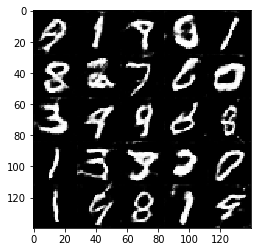

Epoch 2/2... Discriminator Loss: 0.2326... Generator Loss: 3.3189
Epoch 2/2... Discriminator Loss: 0.1830... Generator Loss: 3.0511
Epoch 2/2... Discriminator Loss: 0.4560... Generator Loss: 1.8071
Epoch 2/2... Discriminator Loss: 0.3024... Generator Loss: 1.7683
Epoch 2/2... Discriminator Loss: 0.4899... Generator Loss: 2.3078
Epoch 2/2... Discriminator Loss: 0.2103... Generator Loss: 2.5900
Epoch 2/2... Discriminator Loss: 0.3173... Generator Loss: 2.0768
Epoch 2/2... Discriminator Loss: 0.1427... Generator Loss: 3.4919
Epoch 2/2... Discriminator Loss: 0.1983... Generator Loss: 3.0270
Epoch 2/2... Discriminator Loss: 0.2140... Generator Loss: 3.6457


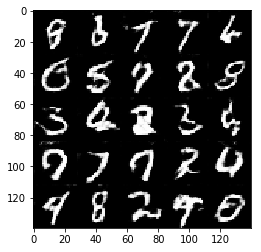

Epoch 2/2... Discriminator Loss: 0.3863... Generator Loss: 2.4982
Epoch 2/2... Discriminator Loss: 0.1984... Generator Loss: 3.5030
Epoch 2/2... Discriminator Loss: 0.1589... Generator Loss: 3.6001
Epoch 2/2... Discriminator Loss: 0.3977... Generator Loss: 1.9772
Epoch 2/2... Discriminator Loss: 0.2358... Generator Loss: 4.1660
Epoch 2/2... Discriminator Loss: 0.5276... Generator Loss: 2.8429
Epoch 2/2... Discriminator Loss: 0.1266... Generator Loss: 3.6234
Epoch 2/2... Discriminator Loss: 0.2664... Generator Loss: 2.7006
Epoch 2/2... Discriminator Loss: 0.3805... Generator Loss: 4.2765
Epoch 2/2... Discriminator Loss: 0.3027... Generator Loss: 2.7750


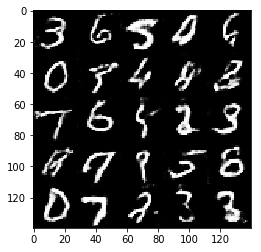

Epoch 2/2... Discriminator Loss: 0.4458... Generator Loss: 2.3232
Epoch 2/2... Discriminator Loss: 0.2058... Generator Loss: 4.3463
Epoch 2/2... Discriminator Loss: 0.7793... Generator Loss: 2.0499
Epoch 2/2... Discriminator Loss: 0.5831... Generator Loss: 4.9054
Epoch 2/2... Discriminator Loss: 0.1306... Generator Loss: 2.9556
Epoch 2/2... Discriminator Loss: 1.2818... Generator Loss: 1.5984
Epoch 2/2... Discriminator Loss: 0.4173... Generator Loss: 2.5518
Epoch 2/2... Discriminator Loss: 0.5856... Generator Loss: 1.6034
Epoch 2/2... Discriminator Loss: 0.3226... Generator Loss: 1.7654
Epoch 2/2... Discriminator Loss: 0.1034... Generator Loss: 2.6104


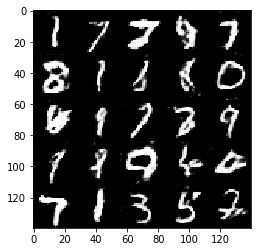

Epoch 2/2... Discriminator Loss: 0.4322... Generator Loss: 2.6868
Epoch 2/2... Discriminator Loss: 0.1786... Generator Loss: 4.2406
Epoch 2/2... Discriminator Loss: 0.1694... Generator Loss: 2.8358
Epoch 2/2... Discriminator Loss: 0.9137... Generator Loss: 6.2114
Epoch 2/2... Discriminator Loss: 0.4215... Generator Loss: 2.8771
Epoch 2/2... Discriminator Loss: 0.1882... Generator Loss: 1.4481
Epoch 2/2... Discriminator Loss: 0.1154... Generator Loss: 3.2730
Epoch 2/2... Discriminator Loss: 0.2229... Generator Loss: 4.7249
Epoch 2/2... Discriminator Loss: 0.5970... Generator Loss: 1.3561
Epoch 2/2... Discriminator Loss: 0.1031... Generator Loss: 4.5130


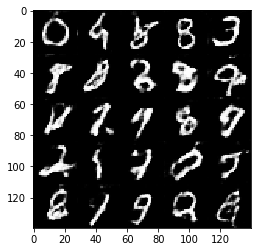

Epoch 2/2... Discriminator Loss: 0.3230... Generator Loss: 1.2166
Epoch 2/2... Discriminator Loss: 0.2940... Generator Loss: 4.1051
Epoch 2/2... Discriminator Loss: 0.6170... Generator Loss: 1.9487
Epoch 2/2... Discriminator Loss: 0.2047... Generator Loss: 3.4710
Epoch 2/2... Discriminator Loss: 0.0709... Generator Loss: 5.4559
Epoch 2/2... Discriminator Loss: 0.2590... Generator Loss: 4.4116
Epoch 2/2... Discriminator Loss: 0.3452... Generator Loss: 3.4187
Epoch 2/2... Discriminator Loss: 0.0892... Generator Loss: 1.7893
Epoch 2/2... Discriminator Loss: 0.2387... Generator Loss: 5.3082
Epoch 2/2... Discriminator Loss: 0.1979... Generator Loss: 2.3442


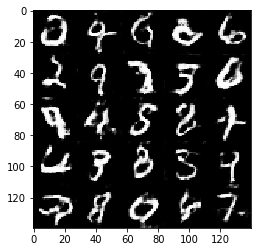

Epoch 2/2... Discriminator Loss: 0.1671... Generator Loss: 1.6953
Epoch 2/2... Discriminator Loss: 0.2222... Generator Loss: 3.5315
Epoch 2/2... Discriminator Loss: 0.7852... Generator Loss: 7.3088
Epoch 2/2... Discriminator Loss: 3.0449... Generator Loss: 7.1221
Epoch 2/2... Discriminator Loss: 0.2379... Generator Loss: 2.5704


In [64]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.8313... Generator Loss: 4.9101
Epoch 1/1... Discriminator Loss: 2.0729... Generator Loss: 1.3043
Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 1.4824
Epoch 1/1... Discriminator Loss: 1.7311... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 1.0210
Epoch 1/1... Discriminator Loss: 1.6014... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.5763
Epoch 1/1... Discriminator Loss: 2.1928... Generator Loss: 2.2152
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 1.0149


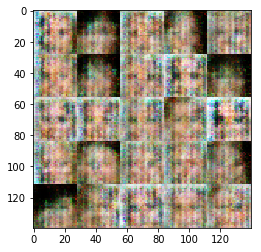

Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.5740... Generator Loss: 0.5253
Epoch 1/1... Discriminator Loss: 1.8527... Generator Loss: 0.9415
Epoch 1/1... Discriminator Loss: 1.8976... Generator Loss: 0.2764
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.7402... Generator Loss: 0.5857


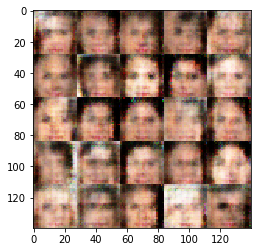

Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.6459... Generator Loss: 0.4437
Epoch 1/1... Discriminator Loss: 1.6723... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.5543... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.6208... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.6471... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.7065


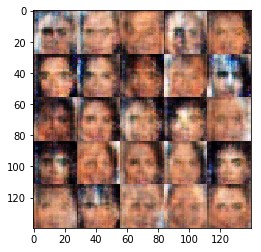

Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.6153... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 1.5443... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.6044... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.5860... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.6920


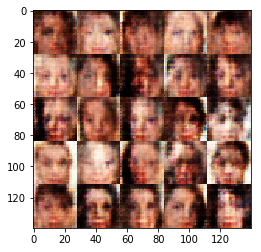

Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.7446


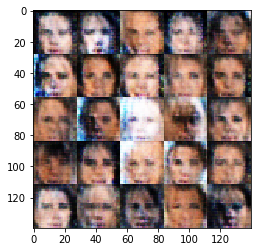

Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 1.5528... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.5851... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.6489


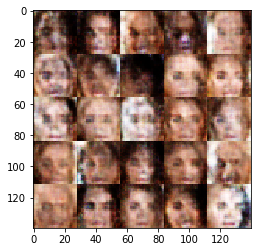

Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.5830... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.7342


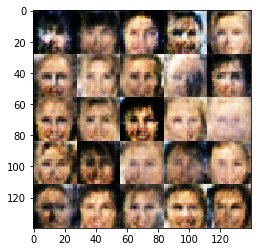

Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.5505
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.5307
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 1.0495


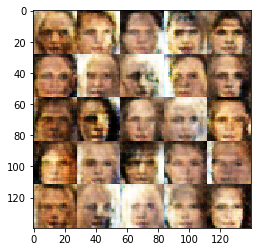

Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.4965
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.5508
Epoch 1/1... Discriminator Loss: 1.5437... Generator Loss: 0.5407


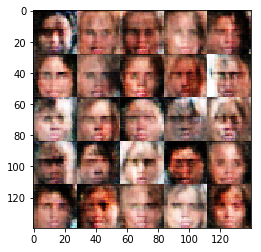

Epoch 1/1... Discriminator Loss: 1.5778... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.5691
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.6734


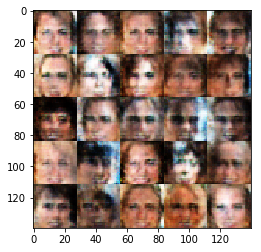

Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.7771


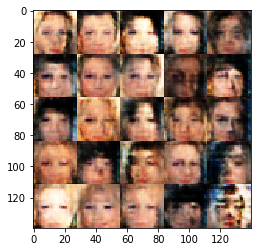

Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.5577
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.6852


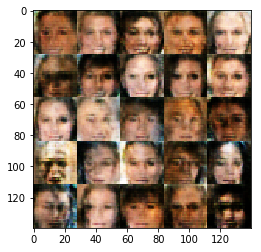

Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.6286... Generator Loss: 0.3574
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.5474
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 1.1375


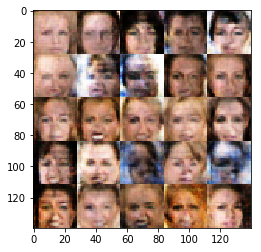

Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.5599


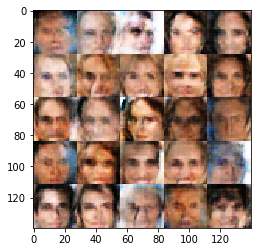

Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.5865
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.5192
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.6671


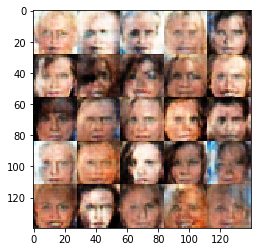

Epoch 1/1... Discriminator Loss: 1.6129... Generator Loss: 0.3361
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.5489... Generator Loss: 0.5535


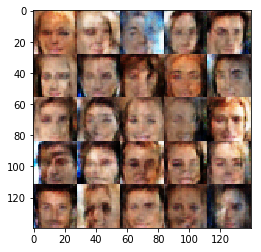

Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.5312... Generator Loss: 0.4889
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.4637
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.5960


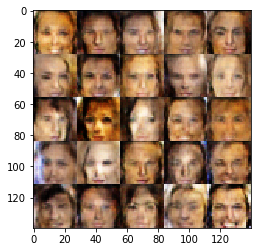

Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 1.1462
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.5552... Generator Loss: 0.4463
Epoch 1/1... Discriminator Loss: 1.6316... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7946


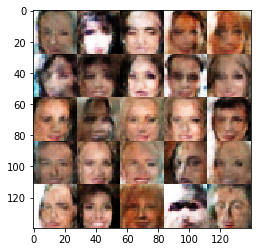

Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.5415
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.9508


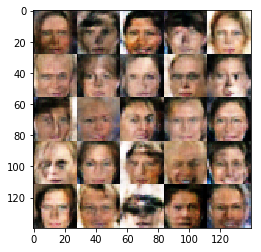

Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.5864


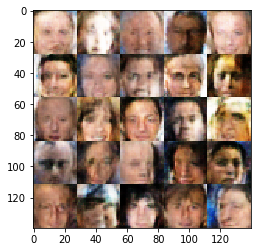

Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6629


In [65]:
batch_size = 100
z_dim = 100
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.